# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [5]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [6]:
with hydra.initialize(config_path="config"):
    '''
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=1_single_image_small'])
    '''
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                  'case=7_small_batch_cifar_pathnet.yaml'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case small_batch_cifar_pathnet with server type path_parameters.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [7]:
num_paths = 8
cfg.case.user.data_idx = 0
cfg.case.user.num_data_points = 1
cfg.case.num_paths = num_paths
cfg.case.server.num_paths = num_paths
#cfg.attack.objective.type = 'euclidean'
cfg.case.server.num_bins = num_paths
#cfg.case.model='ConvNetSmall'
print(cfg.case.server.num_paths)


# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-3

8


### Instantiate all parties

In [8]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Files already downloaded and verified
Model architecture <class 'breaching.cases.models.pathnets.PathNet'> loaded with 11,173,026 parameters and 9,620 buffers.
Overall this is a data ratio of    3637:1 for target shape [1, 3, 32, 32] given that num_queries=1.


In [9]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 1
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: PathNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


In [10]:
print([(i, k, v.shape) for i, (k,v) in enumerate(server.model.named_parameters())])

[(0, 'conv1.weight', torch.Size([64, 3, 3, 3])), (1, 'bn1.weight', torch.Size([64])), (2, 'bn1.bias', torch.Size([64])), (3, 'layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])), (4, 'layer1.0.bn1.weight', torch.Size([64])), (5, 'layer1.0.bn1.bias', torch.Size([64])), (6, 'layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])), (7, 'layer1.0.bn2.weight', torch.Size([64])), (8, 'layer1.0.bn2.bias', torch.Size([64])), (9, 'layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])), (10, 'layer1.1.bn1.weight', torch.Size([64])), (11, 'layer1.1.bn1.bias', torch.Size([64])), (12, 'layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])), (13, 'layer1.1.bn2.weight', torch.Size([64])), (14, 'layer1.1.bn2.bias', torch.Size([64])), (15, 'layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])), (16, 'layer2.0.bn1.weight', torch.Size([128])), (17, 'layer2.0.bn1.bias', torch.Size([128])), (18, 'layer2.0.conv2.weight', torch.Size([128, 128, 3, 3])), (19, 'layer2.0.bn2.weight', torch.Size([128])), (20, 'layer2.0.bn2.

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [11]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

Computing feature distribution before the path_mod layer from external data.
Feature mean is 40.363746643066406, feature std is 14.927318572998047.
> /cmlscratch/lfowl/breaching/breaching/cases/users.py(96)compute_local_updates()
     94             shared_grads += [torch.autograd.grad(loss, self.model.parameters())]
     95             breakpoint()
---> 96             shared_buffers += [[b.clone().detach() for b in self.model.buffers()]]
     97 
     98         shared_data = dict(gradients=shared_grads, buffers=shared_buffers,

ipdb> shared_grads[0][0][:,0,0,0]
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -6.6215e-08,  3.8252e-08,  9.1217e-09, -9.2284e-09,
        -2.0772e-09, -7.4506e-09, -9.6324e-08,  9.2479e-08,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.00

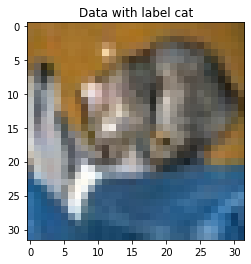

In [12]:
user.plot(true_user_data)

### Reconstruct user data:

In [14]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, setup)

It: 1. Rec. loss: 0.9907. T: 0.03s
It: 1001. Rec. loss: 0.9136. T: 27.28s
It: 2001. Rec. loss: 0.9146. T: 27.36s
It: 3001. Rec. loss: 0.9018. T: 27.20s
Recovery interrupted manually in iteration 3629!
Optimal condidate solution with rec. loss 0.6508 selected.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /cmlscratch/lfowl/miniconda3/envs/decision_bound/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

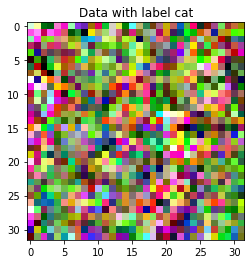

In [15]:
user.plot(reconstructed_user_data)

In [ ]:

print([p for p,_ in server.model.named_parameters()])
print(server.bins)
print(server.bin_val)
print(server.model.path_mod.bias)

In [ ]:
std, mu = server._feature_distribution()
print(std, mu)

In [ ]:
print(server.model.path_mod.weight[0].shape)